# Lens Modeling of DESIJ1501+5208 with Lenstronomy


Author: Mamun Hossain Nahid,  Anowar Shajib \
Acknowledgement: Robin, Tanjela, Nushrat, Imtiaz.

## Import of standard python libraries

In [ ]:
import corner
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
import yaml
from lenstronomy.Analysis.light_profile import LightProfileAnalysis
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, param_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

## Load Imaging Data

In [ ]:
with h5py.File("DESIJ1501+5208_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

In [ ]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"

### Visualizing the Data

<ipython-input-48-357dad159cb2>:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


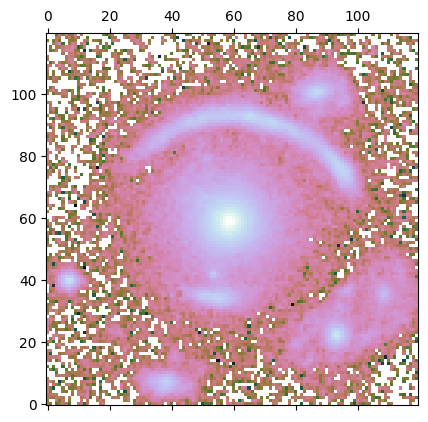

In [ ]:
image_data = kwargs_data["image_data"]
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
plt.show()

## Creating Mask

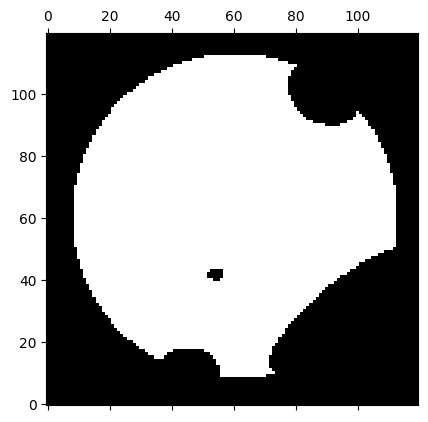

<ipython-input-49-d14db875bb19>:84: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
<ipython-input-49-d14db875bb19>:84: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")


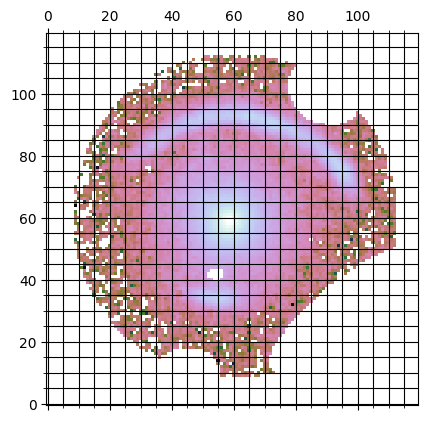

In [ ]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 4.2  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


# for the galaxy at 1 o clock
mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.3,
    lens_center_dec + 3.2,
    1.0,
    0.8,
    np.pi / 0.85,
)


# for the galaxy at 5 o clock
mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.9,
    lens_center_dec - 2.4,
    2.5,
    0.76,
    np.pi / 0.56,
)


# for the galaxy at 7 o clock
mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.2,
    lens_center_dec - 4.0,
    0.8,
    0.6,
    0,
)

# for the galaxy at center
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.5,
    lens_center_dec - 1.5,
    0.2,
    0.15,
    0,
)

mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
)
mask[mask >= 1] = 1
mask[mask < 0] = 0
mask = mask.reshape(num_pix, num_pix)
plt.matshow(mask, origin="lower", cmap="cubehelix")
plt.show()

# applying the mask
masked_image_data = np.multiply(image_data, mask)
plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

## Lens Modeling with Lenstronomy

In [ ]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

### Mass Model for the Lens Galaxy

In [ ]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

EPL Parameters


In [ ]:
fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 2.4990420672610147,
        "gamma": 2.0740006050065145,
        "e1": -0.13171961327694484,
        "e2": -0.12129073509896843,
        "center_x": 0.1139199422234676,
        "center_y": -0.7710651011912243,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 2.0,
        "gamma": 1.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)


Shear Parameters

In [ ]:
fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append(
    {
        "gamma1": 0.024433617943201383,
        "gamma2": -0.0352703510671458,
        "ra_0": 0,
        "dec_0": 0,
    }
)
kwargs_lens_sigma.append({"gamma1": 0.1, "gamma2": 0.1, "ra_0": 0, "dec_0": 0})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3, "ra_0": -100, "dec_0": -100})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3, "ra_0": 100, "dec_0": 100})

### Light Model for the Source Galaxy

In [ ]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

Sersic Ellipse Parameters

In [ ]:
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "amp": 1,
        "R_sersic": 0.25967955801412107,
        "e1": 0.21858978660266953,
        "e2": 0.10639602983475803,
        "center_x": -0.08499420064168527,
        "center_y": 0.10110206519600985,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


Shapelets Parameters

In [ ]:
fixed_source.append({"n_max": 8})
kwargs_source_init.append(
    {
        "amp": 1,
        "n_max": 8,
        "beta": 0.1535239233420192,
        "center_x": -0.08499420064168527,
        "center_y": 0.10110206519600985,
    }
)
kwargs_source_sigma.append({"beta": 0.001, "center_x": 0.2, "center_y": 0.2})
kwargs_lower_source.append({"beta": 0.001, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.2, "center_x": 10, "center_y": 10})

### Light Model for the Lens Galaxy

In [ ]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

1st Sersic Ellipse Parameters

In [ ]:
fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "amp": 1,
        "R_sersic": 0.148577012965974,
        "e1": 0.015281123522442782,
        "e2": 0.020569907245614357,
        "center_x": 0.14345721308983025,
        "center_y": -0.137590783603599,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

2nd Sersic Ellipse Parameters

In [ ]:
fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "amp": 1,
        "R_sersic": 1.0901338596495656,
        "e1": 0.015281123522442782,
        "e2": 0.020569907245614357,
        "center_x": 0.14345721308983025,
        "center_y": -0.137590783603599,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

In [ ]:
def custom_log_likelihood_addition(
    kwargs_lens=None,
    kwargs_source=None,
    kwargs_lens_light=None,
    kwargs_ps=None,
    kwargs_special=None,
    kwargs_extinction=None,
):
    """

    :param kwargs_lens: lens mass model keywords

    :type kwargs_lens: list

    :param kwargs_source: source light model keywords

    :type kwargs_source: list

    :param kwargs_lens_light: lens light model keywords

    :type kwargs_lens_light:  list

    :param kwargs_ps: point source keywords

    :type kwargs_ps: list

    :param kwargs_special: special keywords

    :type kwargs_special: list

    :param kwargs_extinction: extinction model keywords

    :type kwargs_extinction: list

    :return: custom log_likelihood

    :rtype: float

    """

    log_likelihood = 0.0

    mass_phi, mass_q = ellipticity2phi_q(kwargs_lens[0]["e1"], kwargs_lens[0]["e2"])
    light_phi, light_q = ellipticity2phi_q(
        kwargs_lens_light[0]["e1"], kwargs_lens_light[0]["e2"]
    )

    gaussian_std = 0.01
    if mass_q < light_q:
        log_likelihood += -0.5 * (mass_q - light_q) ** 2 / gaussian_std**2

    return log_likelihood

### Combining Source and Lens Models

In [ ]:
joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]
joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y", "e1", "e2"]]]


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_source_with_source": joint_source_with_source,
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
}

## Numerical Settings

In [ ]:
kwargs_likelihood = {
    "custom_logL_addition": custom_log_likelihood_addition,
    "check_bounds": True,
    "image_likelihood_mask_list": [mask],
    "check_positive_flux": True,
}

kwargs_numerics = {"supersampling_factor": 3, "supersampling_convolution": False}

Combining All the Information to be Sent to Lenstronomy

In [ ]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## PSO: Model Fitting

In [ ]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

In [ ]:
fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 200, "n_iterations": 100}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.8370142074840953 reduced X^2 of best position
-3155.9620693187812 log likelihood
7541 effective number of data points
[{'theta_E': 2.514913342113115, 'gamma': 2.0990381424420055, 'e1': -0.05765395955975191, 'e2': -0.05890215027160051, 'center_x': 0.10945282528174662, 'center_y': -0.7288765047768423}, {'gamma1': 0.06884013119980162, 'gamma2': -0.0015685241411298062, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.23047262668250368, 'n_sersic': 1.0, 'e1': 0.19805725027502238, 'e2': 0.046973036157900466, 'center_x': -0.07256847204737808, 'center_y': 0.15850649257038063}, {'amp': 1, 'n_max': 8, 'beta': 0.1523119634243958, 'center_x': -0.07256847204737808, 'center_y': 0.15850649257038063}] source result
[{'amp': 1, 'R_sersic': 0.14945154247732645, 'n_sersic': 1.0, 'e1': 0.022010748964371652, 'e2': 0.02663232519049181, 'center_x': 0.14323999623441344, 'center_y': -0.13752424244511147}, {'am

Save the Best Fit Parameters (PSO)





In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "DESIJ1501+5208_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

##PSO: Visualizing the fitted model

In [ ]:
### load saved best fit parameters ###

load_output_path = "DESIJ1501+5208_pso_output.joblib"
with open(load_output_path, "rb") as f:
    [input_, output_] = joblib.load(f)

(
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
) = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

-0.8199269152489996 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8199269152489239


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
<ipython-input-58-12d54f11901b>:22: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


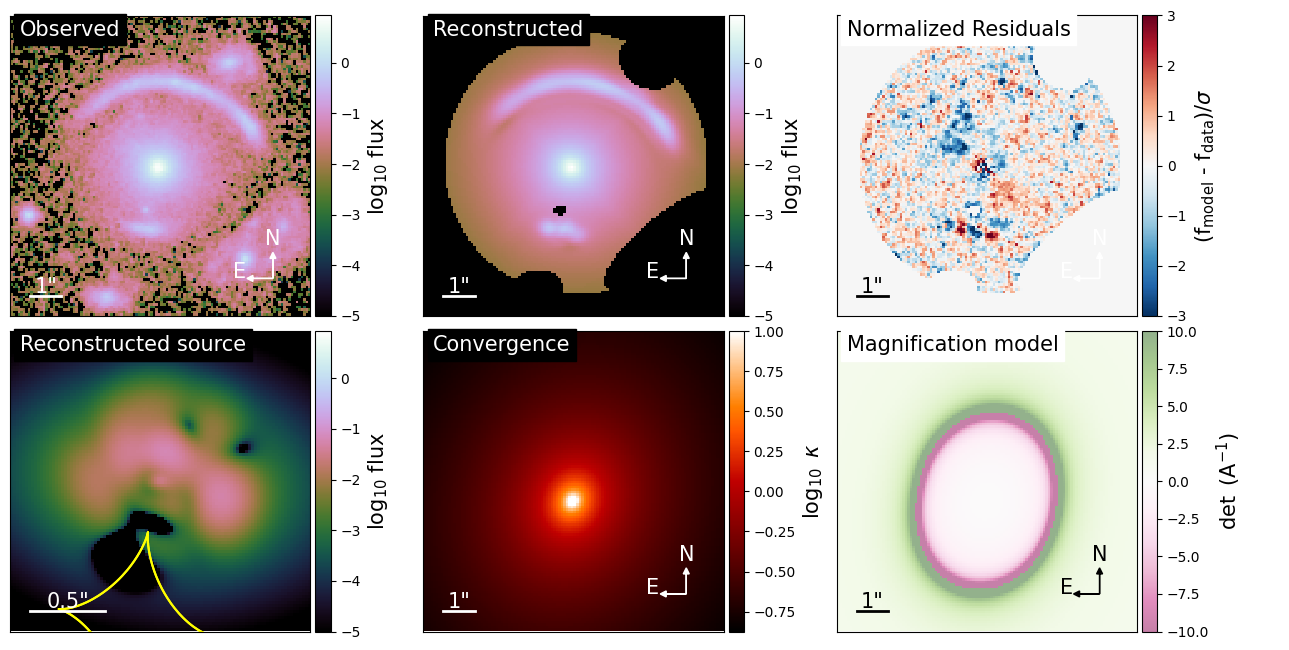

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


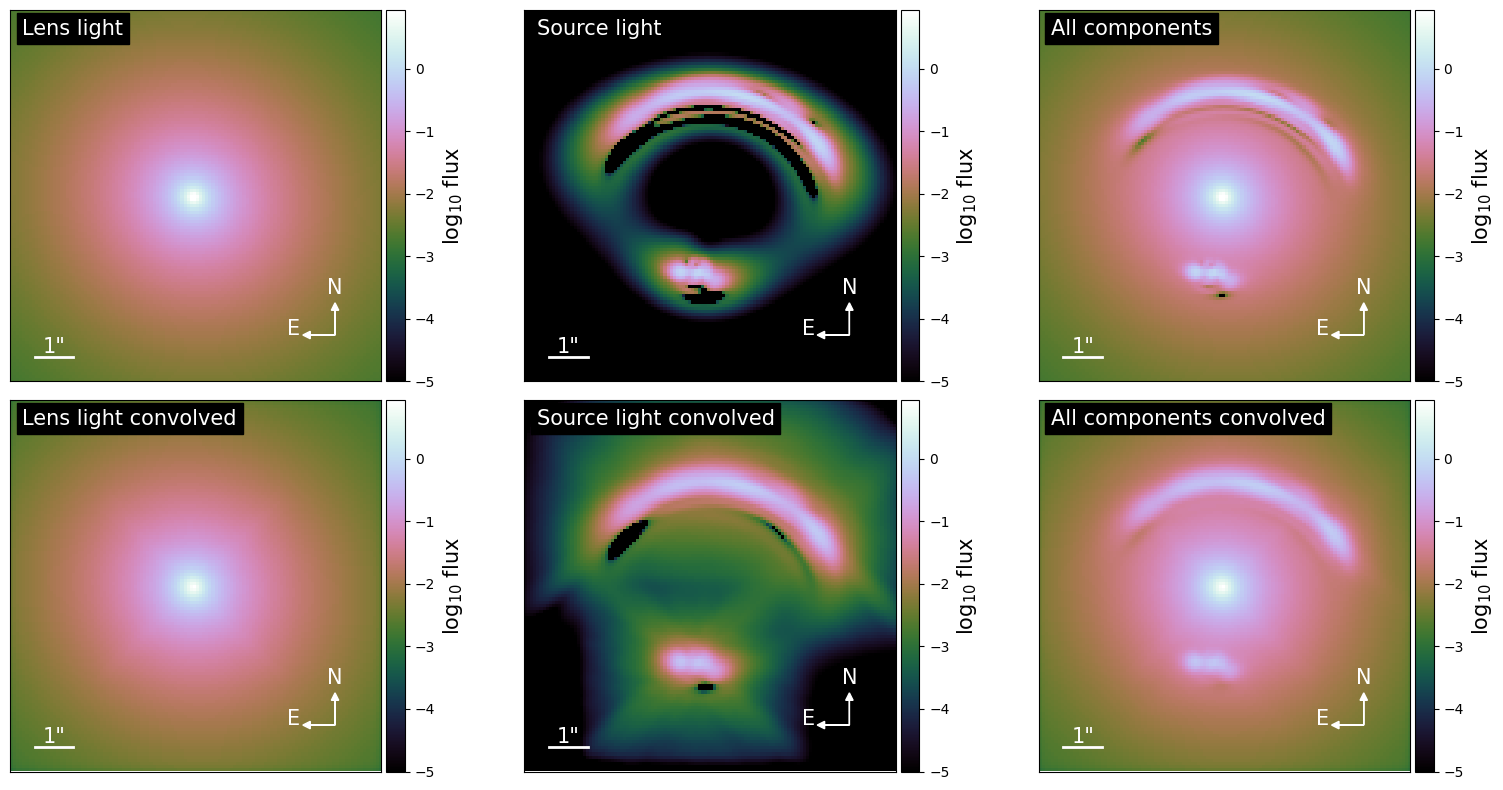

{'kwargs_lens': [{'theta_E': 2.514913342113115, 'gamma': 2.0990381424420055, 'e1': -0.05765395955975191, 'e2': -0.05890215027160051, 'center_x': 0.10945282528174662, 'center_y': -0.7288765047768423}, {'gamma1': 0.06884013119980162, 'gamma2': -0.0015685241411298062, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 43.35302926176312, 'R_sersic': 0.23047262668250368, 'n_sersic': 1.0, 'e1': 0.19805725027502238, 'e2': 0.046973036157900466, 'center_x': -0.07256847204737808, 'center_y': 0.15850649257038063}, {'amp': array([-92.88178713, -32.13380468, 135.33512393,  67.28969076,
        17.14014595, 115.97622015, -26.56702624,  -7.60400003,
        18.52275363,  27.1176273 ,  79.2004559 ,  57.45454605,
        -5.55199549,  26.59813346, -36.21083712, -51.30782962,
       -41.2250479 ,   1.77583114,   1.97258033,  10.63107738,
        -5.40732987,  44.19331244,  27.6357086 ,  19.1704436 ,
        -6.50628887,   8.23427146,   0.3670872 ,  24.09273307,
        -0.47224285, -35.15679003, -16.754

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")


model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, with_caustics=True, scale_size=0.5, numPix=100
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

## MCMC: Model Fitting

In [ ]:
mcmc_backend = "mcmc_backend.h5"

n_walkers = 200
n_step = 2
n_burn = 0

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": n_burn,
            "n_run": n_step,
            "n_walkers": n_walkers,
            "sigma_scale": 0.1,
            "threadCount": 4,
            "backend_filename": mcmc_backend,
            "start_from_backend": True,
        },
    ]
]

fitting_seq_mcmc = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq.best_fit()

100%|██████████| 2/2 [03:07<00:00, 93.53s/it]


Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  0
Sampling iterations (in current run): 2
187.71247339248657 time taken for MCMC sampling


### Trace Plots

In [ ]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

Chain 1:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Shape of samples: (646400, 20)



<ipython-input-67-b288d22036c9>:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 3232, N_walkers: 200, N_params: 20
theta_E_lens0 2.5541 ± 0.0058
gamma_lens0 2.1444 ± 0.0271
e1_lens0 0.0025 ± 0.0099
e2_lens0 -0.0483 ± 0.0051
center_x_lens0 0.0588 ± 0.0060
center_y_lens0 -0.5098 ± 0.0185
gamma1_lens1 0.1069 ± 0.0062
gamma2_lens1 0.0111 ± 0.0029
R_sersic_source_light0 0.1872 ± 0.0096
e1_source_light0 0.0943 ± 0.0225
e2_source_light0 0.0290 ± 0.0229
center_x_source_light0 -0.1082 ± 0.0090
center_y_source_light0 0.2993 ± 0.0277
beta_source_light1 0.1182 ± 0.0057
R_sersic_lens_light0 0.1491 ± 0.0031
e1_lens_light0 0.0172 ± 0.0029
e2_lens_light0 0.0233 ± 0.0026
center_x_lens_light0 0.1433 ± 0.0009
center_y_lens_light0 -0.1376 ± 0.0008
R_sersic_lens_light1 1.0907 ± 0.0230


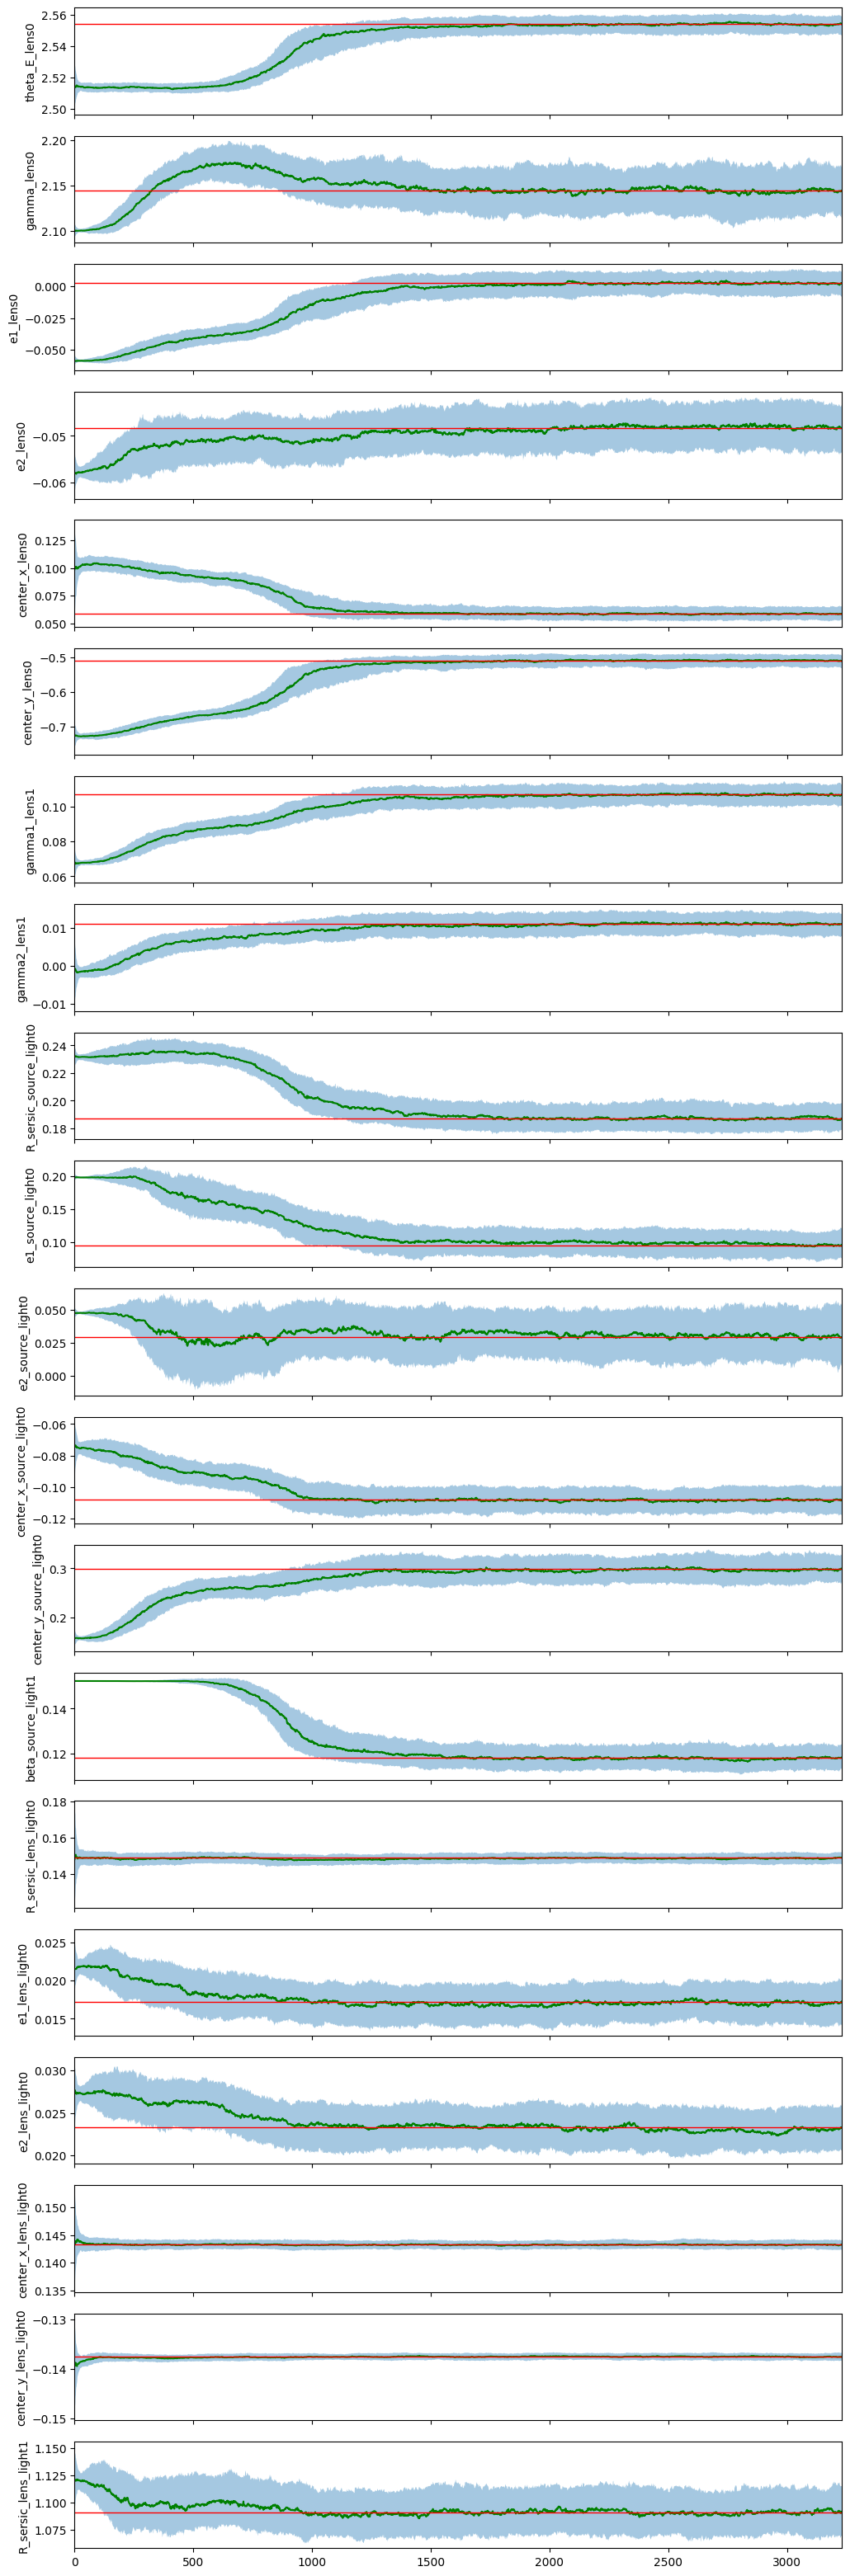

In [ ]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        samples_mcmc = chain_list_mcmc[k][1]

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 200
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

Number of non-linear parameters in the MCMC process: 20
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Number of evaluations in the MCMC process: 646400
646400
Shape of samples_mcmc_cut: (12400, 20)


<ipython-input-71-c498e5d87cde>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


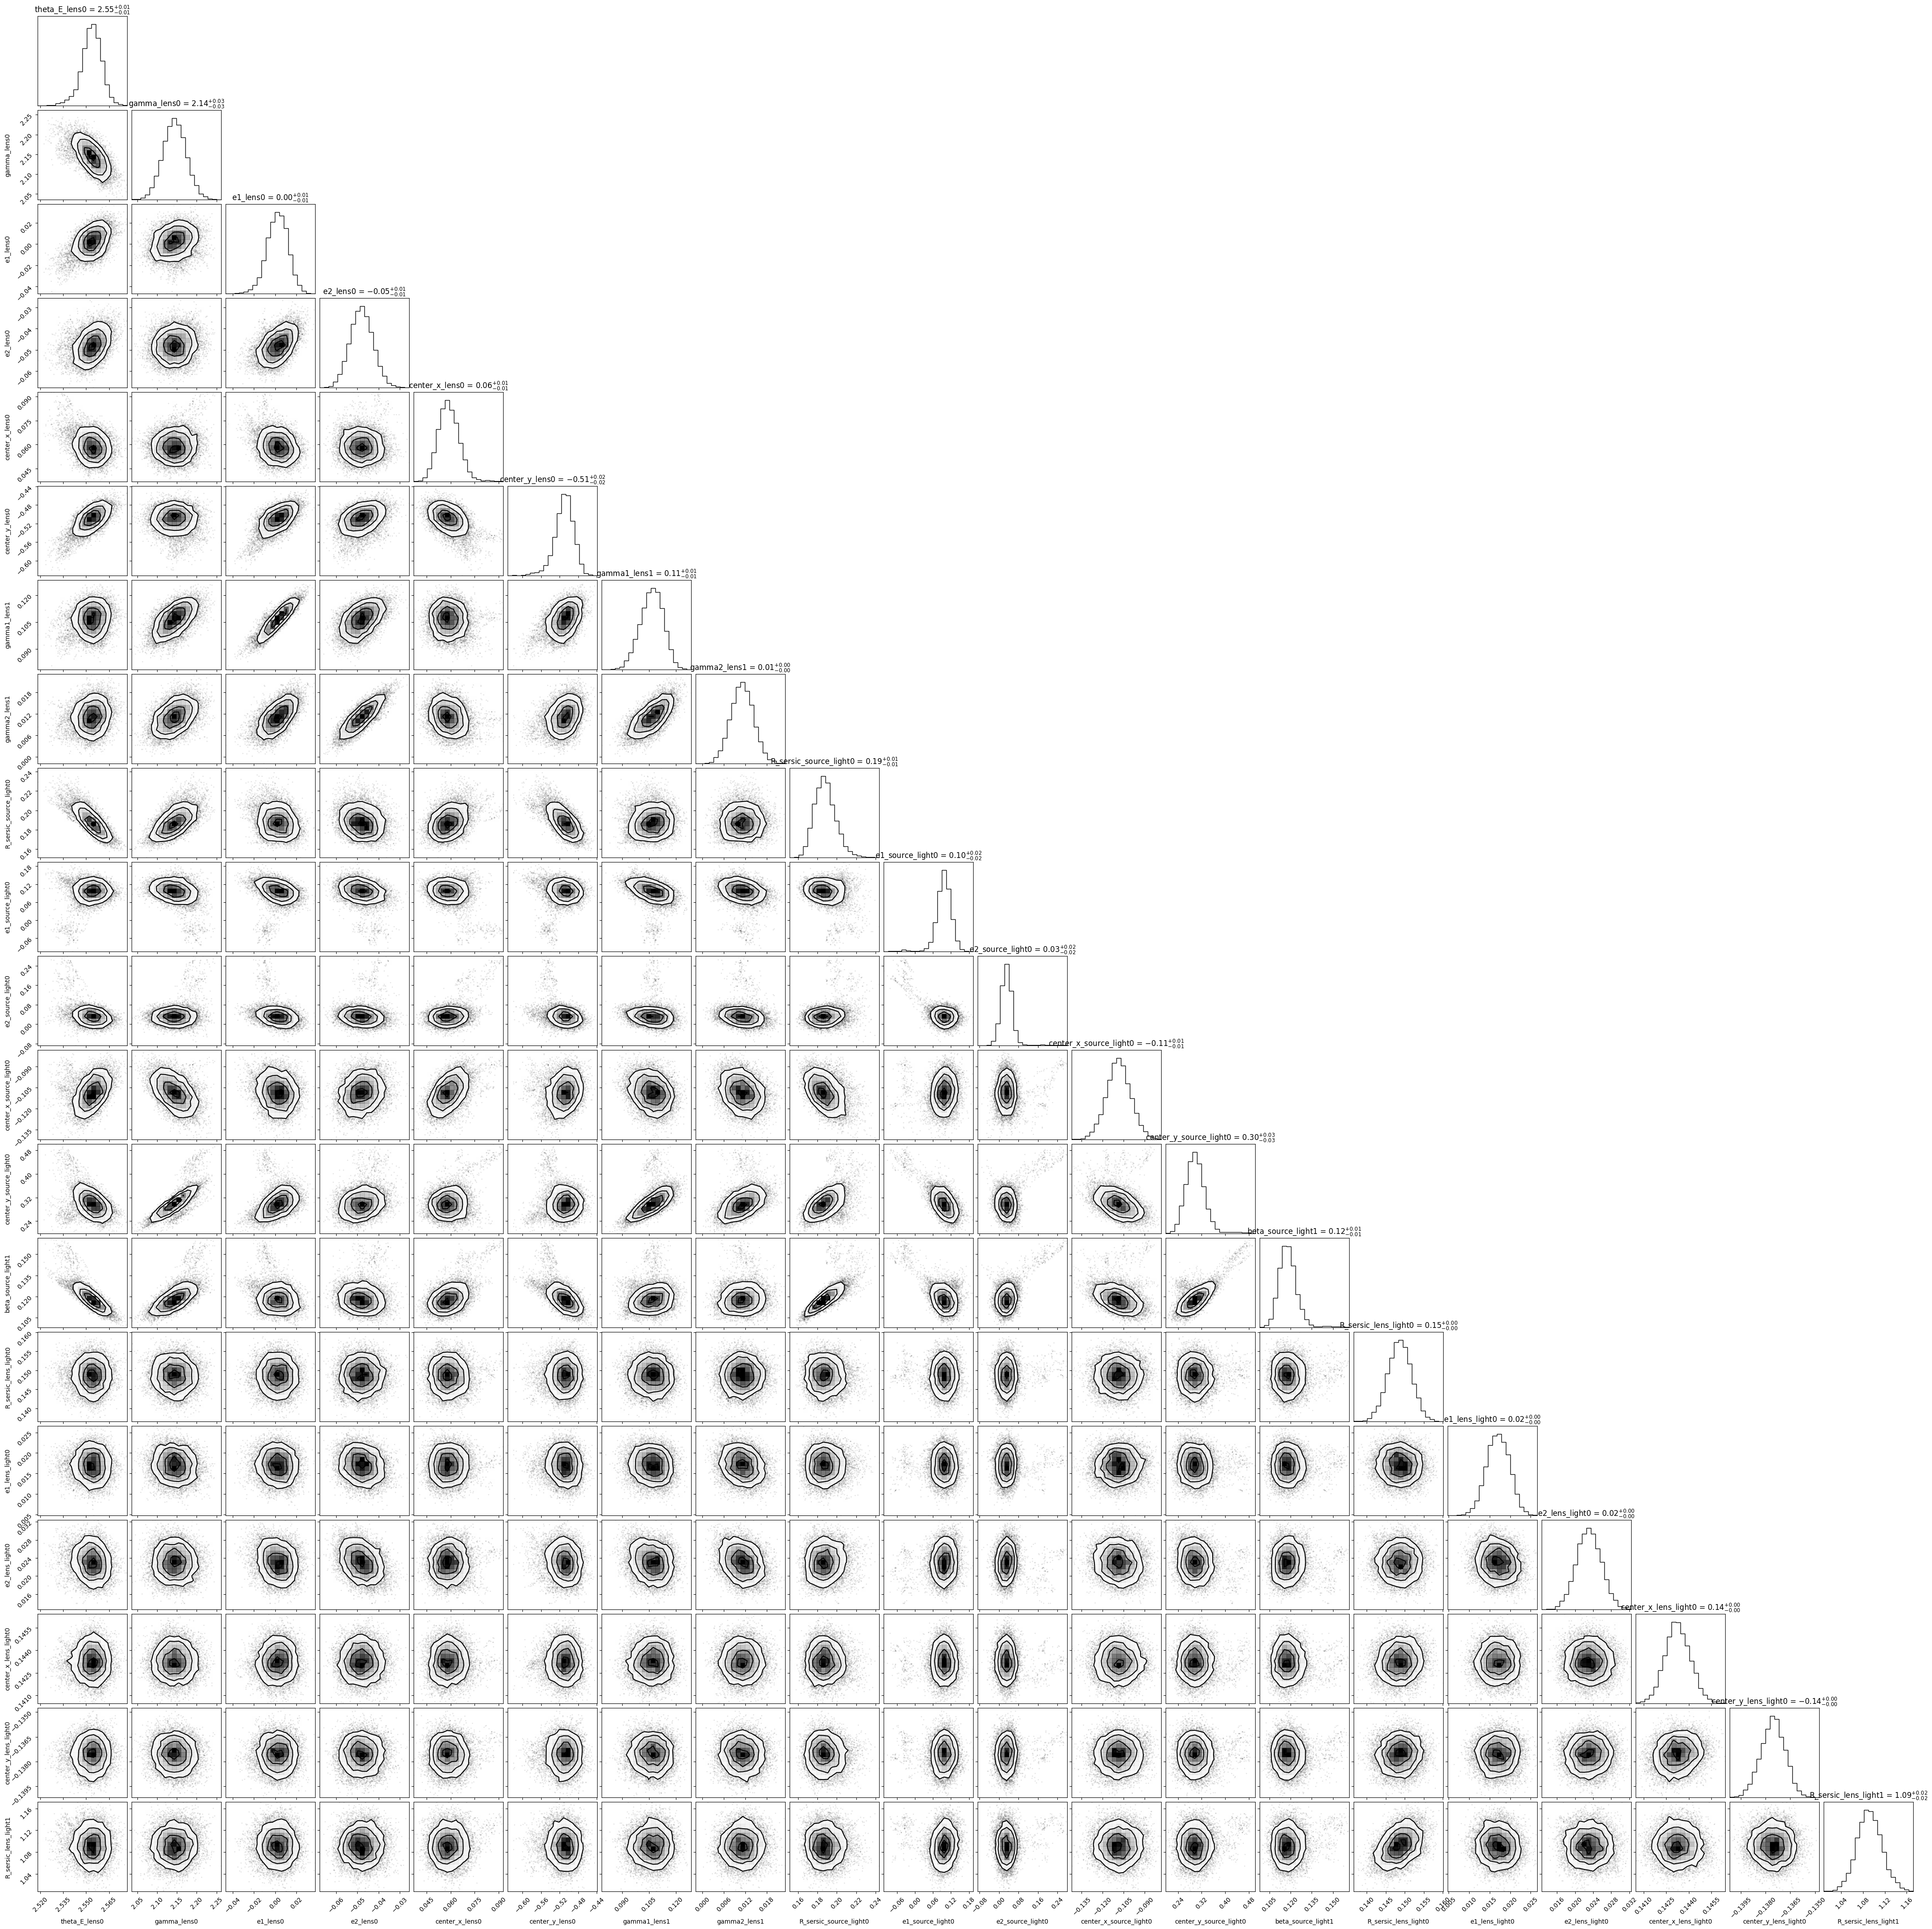

In [ ]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 2000
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

## MCMC: Visualizing the Fitted Model

-0.8211276634681131 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8211276634679863


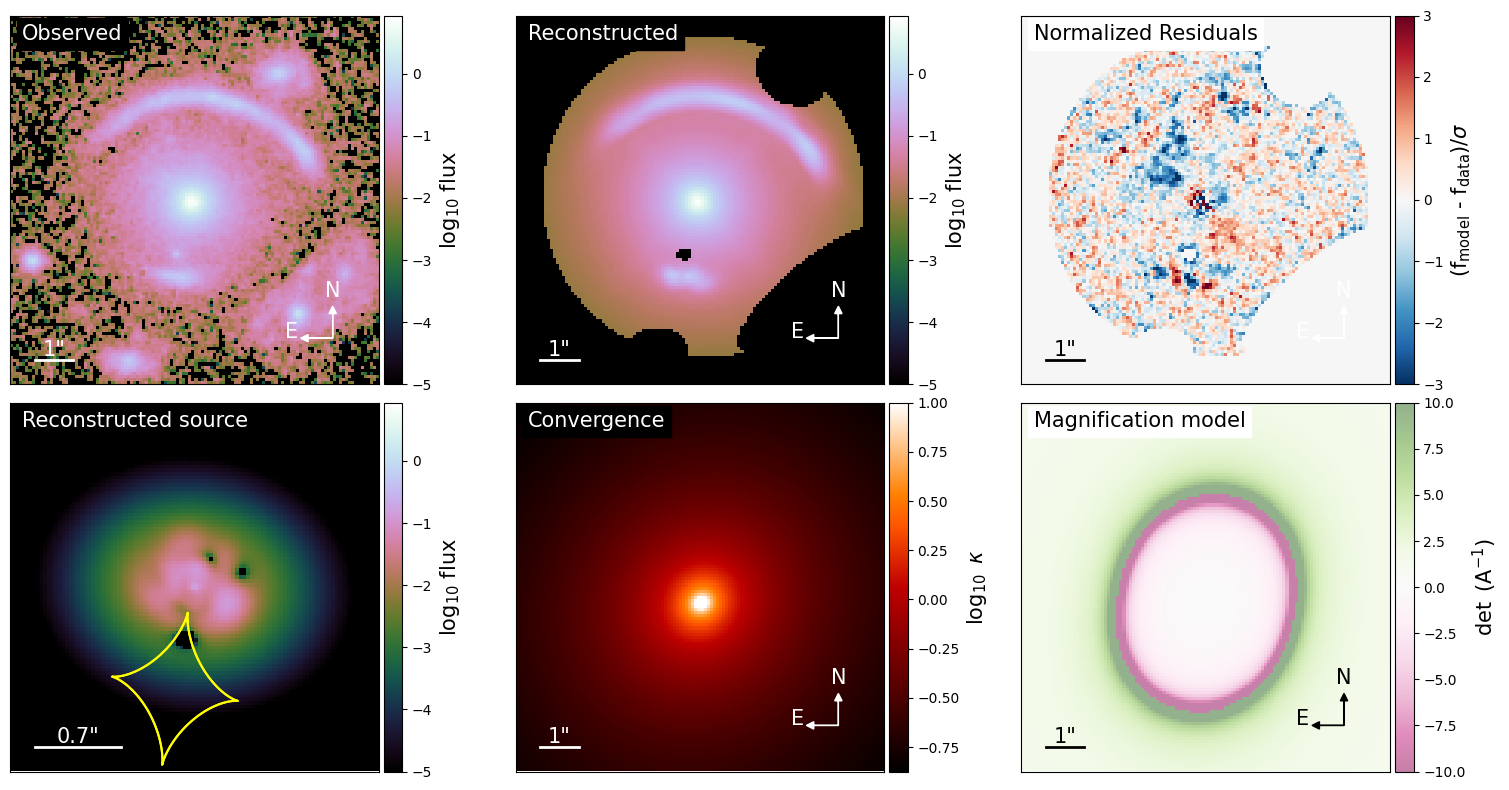

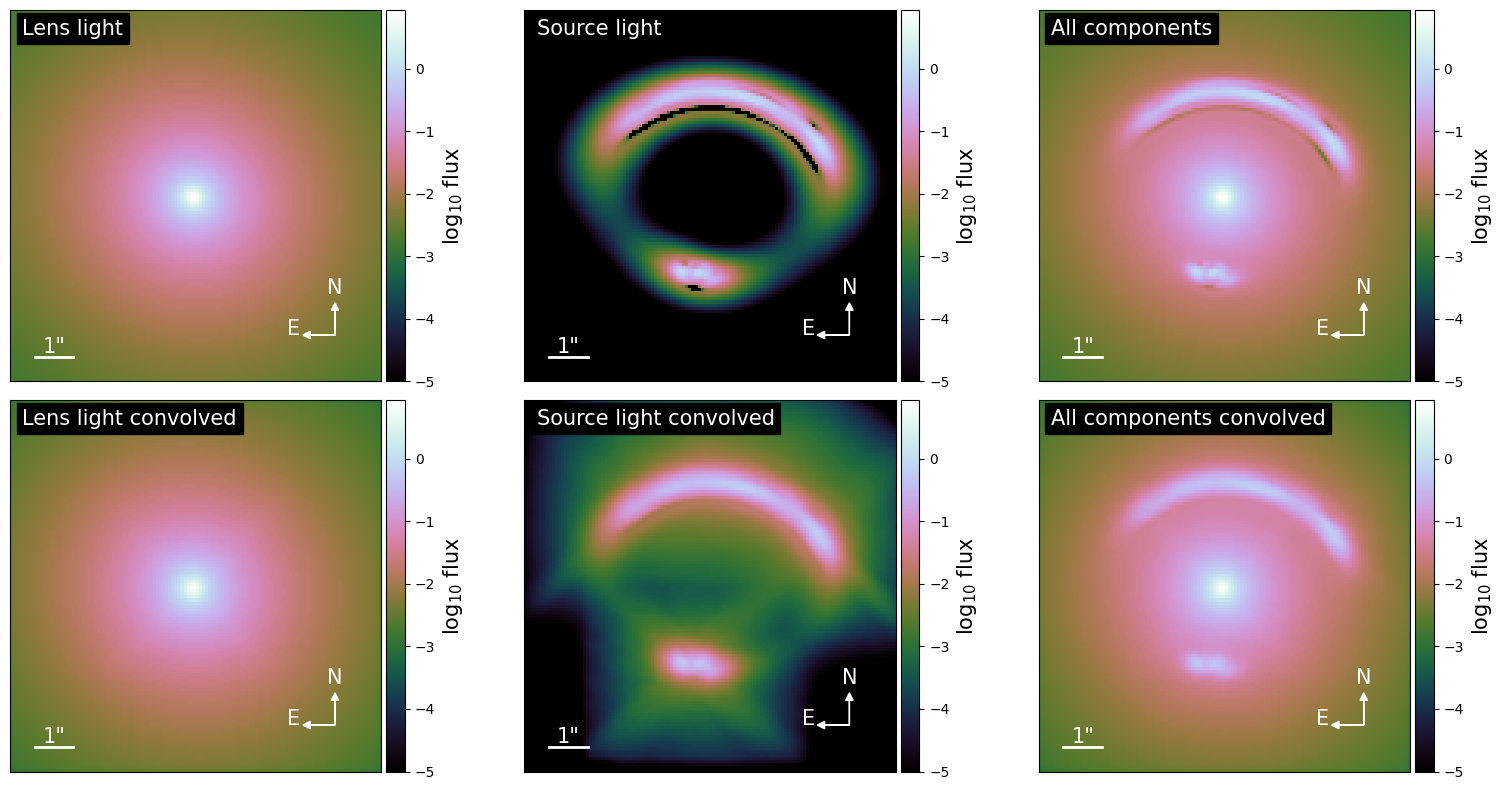

{'kwargs_lens': [{'theta_E': 2.5565248189621945, 'gamma': 2.121370406116233, 'e1': -0.003950881125126772, 'e2': -0.04662956907575759, 'center_x': 0.05531742733487938, 'center_y': -0.5052350047780406}, {'gamma1': 0.10185528736422084, 'gamma2': 0.010505335255146797, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 109.79146384324048, 'R_sersic': 0.17951577459809118, 'n_sersic': 1.0, 'e1': 0.10058753963577602, 'e2': 0.025906400814359208, 'center_x': -0.10290586097754689, 'center_y': 0.26993826038299773}, {'amp': array([-4.30977045e+02, -9.43242475e+00,  7.05951056e+01,  4.10823093e+01,
        5.28070215e+01,  7.42094549e+01, -2.80918893e+01, -6.71896217e+01,
       -5.76534269e+00, -5.94388846e+00,  2.67952038e+01,  6.14769529e+01,
        2.09648351e+00,  3.21760305e+01, -5.13804721e+01, -3.27865544e+01,
       -6.38055915e+01, -3.47032447e+01, -1.30260717e+01, -1.92123693e+00,
        1.43695365e+00,  3.70389624e+00,  1.96458396e+01,  4.86458741e+01,
        3.33106757e+00,  2.277234

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.03, numPix=100, with_caustics=True, scale_size=0.7
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

print(kwargs_result_mcmc)

## Mass and Light Ellipticity of the Lens Galaxy

In [ ]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {},\nmass_phi: {},\nlight_phi: {}, ".format(
        mass_q,
        light_q,
        mass_phi,
        light_phi,
    )
)

mass_q: 0.9105907586369307,
light_q: 0.9470833344745496,
mass_phi: -0.827661766042401,
light_phi: 0.477201695531741, 


Save the Best Fit Parameters (MCMC)

In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

# Defining shortened_samples_mcmc
if samples_mcmc is not None:
    print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    burnin = 3132
    thin = 20
    shortened_samples_mcmc = chain[:, burnin::thin, :].reshape((-1, n_params))
print("Shape of shortened_samples_mcmc:", shortened_samples_mcmc.shape)


output = [
    kwargs_result_mcmc,
    multi_band_list_out,
    kwargs_fixed_out,
    shortened_samples_mcmc,
    param_mcmc,
]

output_path = "DESIJ1501+5208_mcmc_output.joblib"


with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=9)

Number of evaluations in the MCMC process: 646400
646400
Shape of shortened_samples_mcmc: (1000, 20)


### Parameters without Conversion

In [ ]:
# The list of parameters to be included in the yaml file without conversion
list_params = [
    "theta_E_lens0",
    "gamma_lens0",
    "center_x_lens0",
    "center_y_lens0",
    "center_x_lens_light0",
    "center_y_lens_light0",
]

# Uncertainty calculation
median_sample = np.zeros(n_params)
q16_sample = np.zeros(n_params)
q84_sample = np.zeros(n_params)
values = {}

for i in range(n_params):
    median_sample[i] = np.median(shortened_samples_mcmc[:, i])
    q16_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 16.0)
    q84_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 84.0)

    values[param_mcmc[i]] = [
        median_sample[i],
        q84_sample[i] - median_sample[i],
        median_sample[i] - q16_sample[i],
    ]
# parameters filtered by list params
parameter_values = {k: values.get(k) for k in list_params}
print("\n", parameter_values)  # ['theta_E_lens0'][0])


 {'theta_E_lens0': [2.553501710622605, 0.005802238923427794, 0.0061155885897741236], 'gamma_lens0': [2.144060299504608, 0.02863136405684008, 0.02698243532947986], 'center_x_lens0': [0.058598016567189035, 0.006702337114232293, 0.006031763710937527], 'center_y_lens0': [-0.5096104909433775, 0.018346213251418553, 0.019112186449885882], 'center_x_lens_light0': [0.1432446742122358, 0.0008889154287016754, 0.0009319579631293096], 'center_y_lens_light0': [-0.13761715729908422, 0.0007686040139971151, 0.0007523707046324102]}


In [ ]:
# Mapping of old parameter names to new parameter names
param_name_mapping = {
    "theta_E_lens0": "theta_E",
    "gamma_lens0": "gamma",
    "center_x_lens0": "center_x_mass",
    "center_y_lens0": "center_y_mass",
    "center_x_lens_light0": "center_x_light",
    "center_y_lens_light0": "center_y_light",
}

# Rename parameters in the parameter_values dictionary
parameter_values = {
    param_name_mapping.get(k, k): v for k, v in parameter_values.items()
}


for key, value in parameter_values.items():
    print(f"{key}: {value}")

theta_E: [2.553501710622605, 0.005802238923427794, 0.0061155885897741236]
gamma: [2.144060299504608, 0.02863136405684008, 0.02698243532947986]
center_x_mass: [0.058598016567189035, 0.006702337114232293, 0.006031763710937527]
center_y_mass: [-0.5096104909433775, 0.018346213251418553, 0.019112186449885882]
center_x_light: [0.1432446742122358, 0.0008889154287016754, 0.0009319579631293096]
center_y_light: [-0.13761715729908422, 0.0007686040139971151, 0.0007523707046324102]


### Parameters with Conversion

In [ ]:
# Initial parameters list
list_params_prior = [
    "e1_lens0",
    "e2_lens0",
    "gamma1_lens1",
    "gamma2_lens1",
    "e1_lens_light0",
    "e2_lens_light0",
]

# converted parameters list

list_params_posterior = [
    "phi_mass",
    "q_mass",
    "phi_shear",
    "gamma_shear",
    "phi_light",
    "q_light",
]

n_params_prior = len(list_params_prior)
n_params_posterior = len(list_params_posterior)
length_shortened = len(shortened_samples_mcmc)

prior_samples = np.zeros((length_shortened, n_params_prior))

# Copying the selected (prior) parameters from shortened samples
for j in list_params_prior:
    if j in param_mcmc:
        prior_samples[:, list_params_prior.index(j)] = shortened_samples_mcmc[
            :, param_mcmc.index(j)
        ]
    else:
        print(f"Warning: Parameter '{j}' not found in param_mcmc.")


# Initializing an array for saving the converted parameter values
posterior_samples = np.zeros((length_shortened, n_params_posterior))

for i in range(0, n_params_posterior, 2):
    if i == 0 or i == 4:
        for j in range(length_shortened):
            (
                posterior_samples[j][i],
                posterior_samples[j][i + 1],
            ) = param_util.ellipticity2phi_q(
                prior_samples[j][i], prior_samples[j][i + 1]
            )
    elif i == 2:
        for k in range(length_shortened):
            (
                posterior_samples[k][i],
                posterior_samples[k][i + 1],
            ) = param_util.shear_cartesian2polar(
                prior_samples[k][i], prior_samples[k][i + 1]
            )
            # print(posterior_samples[k][i], posterior_samples[k][i+1])
    else:
        print("Array Index Out of Range")

# Uncertainty calculation
median_sample_posterior = np.zeros(n_params_posterior)
q84_sample_posterior = np.zeros(n_params_posterior)
q16_sample_posterior = np.zeros(n_params_posterior)

values_posterior = {}


for i in range(n_params_posterior):
    median_sample_posterior[i] = np.median(posterior_samples[:, i])
    q16_sample_posterior[i] = np.percentile(posterior_samples[:, i], 16.0)
    q84_sample_posterior[i] = np.percentile(posterior_samples[:, i], 84.0)

    values_posterior[list_params_posterior[i]] = [
        median_sample_posterior[i],
        q84_sample_posterior[i] - median_sample_posterior[i],
        median_sample_posterior[i] - q16_sample_posterior[i],
    ]
# print(values_posterior)
# marge previous parameters and new converted parameters
parameter_values.update(values_posterior)
print(parameter_values)

{'theta_E': [2.553501710622605, 0.005802238923427794, 0.0061155885897741236], 'gamma': [2.144060299504608, 0.02863136405684008, 0.02698243532947986], 'center_x_mass': [0.058598016567189035, 0.006702337114232293, 0.006031763710937527], 'center_y_mass': [-0.5096104909433775, 0.018346213251418553, 0.019112186449885882], 'center_x_light': [0.1432446742122358, 0.0008889154287016754, 0.0009319579631293096], 'center_y_light': [-0.13761715729908422, 0.0007686040139971151, 0.0007523707046324102], 'phi_mass': [-0.7644187046338623, 0.10699233249422724, 0.09021138910958693], 'q_mass': [0.9065524912121286, 0.008166846680169204, 0.009642283348029967], 'phi_shear': [0.05186381027451778, 0.011692279036570663, 0.013632563624703421], 'gamma_shear': [0.10730543894702567, 0.0061416043730661285, 0.006302747094289116], 'phi_light': [0.46882311463832016, 0.04982981394332564, 0.04753113723271507], 'q_light': [0.9440798440047046, 0.00475424200002772, 0.0049969421514478585]}


### Half light radius calculation

In [ ]:
light_model = LightModel(lens_light_model_list)
analysis = LightProfileAnalysis(light_model)

# Providing the lens light results from MCMC
kwargs_light = kwargs_result_mcmc["kwargs_lens_light"]

# Calculate the half-light radius
half_light_radius = analysis.half_light_radius(
    kwargs_light, grid_spacing=0.01, grid_num=10 / 0.01
)
print("Half-light radius:", half_light_radius)

# Adding to the dictionary
parameter_values["R_eff_light"] = half_light_radius
print("\n", parameter_values)

Half-light radius: 0.7205276678934682

 {'theta_E': [2.553501710622605, 0.005802238923427794, 0.0061155885897741236], 'gamma': [2.144060299504608, 0.02863136405684008, 0.02698243532947986], 'center_x_mass': [0.058598016567189035, 0.006702337114232293, 0.006031763710937527], 'center_y_mass': [-0.5096104909433775, 0.018346213251418553, 0.019112186449885882], 'center_x_light': [0.1432446742122358, 0.0008889154287016754, 0.0009319579631293096], 'center_y_light': [-0.13761715729908422, 0.0007686040139971151, 0.0007523707046324102], 'phi_mass': [-0.7644187046338623, 0.10699233249422724, 0.09021138910958693], 'q_mass': [0.9065524912121286, 0.008166846680169204, 0.009642283348029967], 'phi_shear': [0.05186381027451778, 0.011692279036570663, 0.013632563624703421], 'gamma_shear': [0.10730543894702567, 0.0061416043730661285, 0.006302747094289116], 'phi_light': [0.46882311463832016, 0.04982981394332564, 0.04753113723271507], 'q_light': [0.9440798440047046, 0.00475424200002772, 0.004996942151447858

### Creating the YAML file

In [ ]:
# make all the numpy variales to float
parameter_values = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in parameter_values.items()
}

# Write the dictionary to a YAML file
yaml_file_name = "DESIJ1501+5208_point_estimates.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(parameter_values, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")

YAML file '/content/drive/MyDrive/with log likelihood 2/DESIJ1501+5208_point_estimates.yml' created successfully.


### Read the YAML file using safe_load

In [ ]:
yaml_file_name = "DESIJ1501+5208_point_estimates.yml"
with open(yaml_file_name, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': 0.7205276678934682, 'Sigma_10': 0.0429640906386594, 'Sigma_10_flux_selected': 0.04108377164514739, 'Sigma_20': 0.04851014874936145, 'Sigma_20_flux_selected': 0.04287439538563224, 'center_x_light': [0.1432446742122358, 0.0008889154287016754, 0.0009319579631293096], 'center_x_mass': [0.058598016567189035, 0.006702337114232293, 0.006031763710937527], 'center_y_light': [-0.13761715729908422, 0.0007686040139971151, 0.0007523707046324102], 'center_y_mass': [-0.5096104909433775, 0.018346213251418553, 0.019112186449885882], 'gamma': [2.144060299504608, 0.02863136405684008, 0.02698243532947986], 'gamma_shear': [0.10730543894702567, 0.0061416043730661285, 0.006302747094289116], 'phi_light': [0.46882311463832016, 0.04982981394332564, 0.04753113723271507], 'phi_mass': [-0.7644187046338623, 0.10699233249422724, 0.09021138910958693], 'phi_shear': [0.05186381027451778, 0.011692279036570663, 0.013632563624703421], 'q_light': [0.9440798440047046, 0.004754